# UFO

<font color='#660066'>
   
### Table of Contents

- [Data](#Data)
    - [Scraping from UFORC](#Scraping-from-UFORC)
    - [Data Format](#data_format)
    - [Cleaing Data](#cleaning_pdata)
- [Basic anlayis](#Basic-Anylsis)
- [Milestone 3](#milestones)

In [8]:
%load_ext autoreload
%autoreload 2
import json
import pandas as pd
from lib.scraping import fetch_shape_urls,  \
                     fetch_all_sighting_urls, \
                     store_to_json, \
                     build_report_dataframe
from lib.postprocessing import get_time_of_occurrence, \
                           to_datetime_add_year, \
                           replace_empty_with_nan, \
                           distribution_histogram 
from lib.cleaning import clean_data, \
                        clean_duration_get_min
from lib.nuforc_analysis import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_folder = "data/"

file_url_list = data_folder+'full_list_of_urls.json'

report_file = 'jurgis_full.csv'

<font color='#660066'>
   
# Data

## Scraping from UFORC

The National UFO Reporting Center (**NUFORC**) lists reports splitted by the occured date, by posting date, by shape or by location. These sightings has been collected since 1974. NUFORC provides a [Hotline](http://www.nuforc.org/Report.html) or [web formular]() to submit the UFO encounters. These reports are checked for hoax and fake reporst, according to [several reports](https://www.reddit.com/r/UFOs/comments/6h5jfc/nuforc_filters_their_reports_much_better_than/). The sightings also include articles from news papers and historical accounts.

We decided to scrape the data from their web page using the *request* and *beatifulsoup* libraries. 

The first step to fetch all the possible shapes and then we can fetch all the urls from each of the shape. 



In [3]:
all_shapes = fetch_shape_urls()
all_reporting_urls = fetch_all_sighting_urls(all_shapes)

<font color='#660066'>

Let's see how many shapes and reportings there are: 

In [4]:
print("Number of shapes:", len(all_shapes))
print("Nubmer of sighting:", len(all_reporting_urls))

Number of shapes: 31
Nubmer of sighting: 117644


<font color='#660066'>

We don't want to constantly send requests to the server, therefore store the file in urls in a json file. 

In [ ]:
store_to_json(all_reporting_urls, file_url_list)

In [ ]:
# import href list of each report
with open(file_url_list) as train_file:
    href_data = json.load(train_file)
urls_to_read = href_data['url']['0']

<font color='#660066'>

Now we are ready to fetch all the reports and convert it to a Pandas Dataframe.

In [ ]:
%%time
df_reports = build_report_dataframe(urls_to_read)

In [ ]:
df_reports.to_json(data_folder+"all_sightings.json")

<font color='#660066'>

The whole scraping process took more than 1 hour. 

<font color='#660066'>
    
## Loading data

of course we dont want so scrape every time

In [150]:
df_reports = pd.read_csv(data_folder+report_file)
df_reports.sample(1).head()

,Unnamed: 0,Duration,Location,Occurred,Posted,Reported,Shape,Summary,url
65053,52870,3 seconds,"Gilford, NH",4/29/2016 10:25 (Entered as : 04/29/16 10:25),4/29/2016,4/29/2016 10:08:39 AM 10:08,Light,['Meteor-like silver-gray bright object seen f...,http://www.nuforc.org/webreports/127/S127099.html


In [151]:
df_reports, df_madarr = clean_data(df_reports)

<font color='#660066'>
   
The data contains the following columns: 

- Occurred
- Reported
- Posted
- Location
- Shape
- Duration
- Summary

The following sections analyze these data throughly. 

In [147]:
df_reports = df_reports.set_index('url')

In [148]:
df_reports.head()

,Duration,Location,State,Occurred,Posted,Reported,Shape,Summary,nuforc_note,link
url,,,,,,,,,,
http://www.nuforc.org/webreports/143/S143627.html,10 minutes,Lutz,FL,2018-10-30 23:30:00,11/9/2018,2018-10-30 20:54:00,,['Blinking white light that moved every few se...,[((NUFORC Note: We have attempted to contact ...,[]
http://www.nuforc.org/webreports/089/S89377.html,4-5 minutes,Bridgewater,NJ,2011-11-23 00:45:00,6/5/2012,2012-06-05 12:37:00,,['EXPLAINED: Bright lights in Somerset county ...,[((NUFORC Note: Witness elects to remain tota...,[http://www.nj.com/news/index.ssf/2011/11/brig...
http://www.nuforc.org/webreports/019/S19862.html,2 min,South Fork,CO,2001-10-04 14:00:00,3/21/2003,2001-10-15 13:27:00,Cigar,"['Shinny Cigar shape in sky on clear day.', 'D...",[],[]
http://www.nuforc.org/webreports/121/S121007.html,10 minutes,Hattiesburg,MS,2014-12-17 20:00:00,8/13/2015,2015-08-09 21:11:00,Triangle,['I saw a triangular UFO with red and white li...,[],[]
http://www.nuforc.org/webreports/116/S116071.html,5-10 seconds,LaBelle,FL,2014-12-17 17:19:00,12/18/2014,2014-12-17 18:21:00,Triangle,"['White Triangle in South Florida', 'My co-wor...",[],[]


In [149]:
duration = clean_duration_get_min(df_reports)

KeyError: '[111938 97125 92361 87440 110228 45333 80653 58194 55810 54939 110807\n 54694 30841 57254] not found in axis'

In [140]:
df_dummy = df_reports.copy()

In [142]:
df_dummy = df_dummy.set_index('url')

In [107]:
df_dummy.Duration = np.nan

In [144]:
duration = duration.to_frame()

In [137]:
df_duration = df_dummy.Duration.to_frame()
df_duration = df_duration.reset_index()
duration = df_duration.reset_index()

In [146]:
df_dummy.Duration.update(duration.Duration)

ValueError: cannot reindex from a duplicate axis

In [139]:
df_duration

,index,Duration
0,0,NaN
1,4,NaN
2,5,NaN
3,6,NaN
4,7,NaN
5,8,NaN
6,9,NaN
7,10,NaN
8,11,NaN
9,12,NaN


In [130]:
#duration = duration.to_frame()
#df_dummy.merge(duration, how='right', left_on='Duration', right_on='Duration')
df_dummy.Duration.update(duration.Duration)

ValueError: cannot reindex from a duplicate axis

In [96]:
duration = duration.rename(index=str, columns={'Duration':'abc'})

In [111]:
df_dummy.Duration.update(duration)

ValueError: cannot reindex from a duplicate axis

<font color='#660066'>
    
## Cleaning data

Let's see how many are not fetched:

In [12]:
df_reports.Duration = np.nan

In [7]:
not_found_reports = df_reports[pd.isnull(df_reports.Summary)]
print("Not found reports", not_found_reports.count()['url'])

Not found reports 105


<font color='#660066'>

These are reports which were not fetched correctly, we have to investigate further why these are missing. 

In [8]:
df_every_thing = df_reports.rename(index=str, columns={'Occurred ':'Occurred'})

<font color='#660066'>

In our dataset we noticed there are several emtpy strings. <br/>
We decided exchange these empty strings with NaN for easier parsing. 

In [9]:
df_every_thing = replace_empty_with_nan(df_every_thing, 'Occurred')

Occurred feature has 156 missing values


<font color='#660066'>

The function below does raw post processing on the scraped data such as cleaning whitespace, renaming the columns, ordering the columns and applies filters so that we only retrieve the desired data wich contains summary data and sufficient information for the states.


In [497]:
df_ufo_reports = post_process(df_reports)

splitting Location..


C:\Users\jurgi\Desktop\JURGIS\ADA\ada_project\lib\cleaning.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_ufo_reports['Location'] = df_splitted_locaiton.str[0]
C:\Users\jurgi\Desktop\JURGIS\ADA\ada_project\lib\cleaning.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_ufo_reports['State'] = df_splitted_locaiton.str[1]


cleaning Location..


C:\Users\jurgi\Desktop\JURGIS\ADA\ada_project\lib\cleaning.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_ufo_reports['Location'] = df_ufo_reports['Location'].astype(str).apply(lambda x: x.strip())


cleaning State..
cleaning Reported
cleaning Posted..
re-ordering columns..
done


<font color='#660066'>

Spliting all nuforc notes of each summary into a seperate column.


In [11]:
df_ufo_reports = split_nuforc_notes_from_summary(df_ufo_reports)

In [12]:
df_ufo_reports[["Summary","nuforc_note"]].sample(5)

,Summary,nuforc_note
100418,['Flashing red/ orange strobe like light with...,[((NUFORC Note: Witness elects to remain tota...
8126,['saw craft hovering over corn feild. craft ha...,[]
108568,['Orange/red glowing orbs moving in procession...,[]
3817,"['Triangle in sky hovered for several minutes,...",[]
23287,['A large bright orange glowing ball floating ...,[]


<font color='#660066'>

### Occurred / Reported / Posted

In [13]:
converted = get_time_of_occurrence(df_every_thing)

C:\Users\jurgi\Desktop\JURGIS\ADA\ada_project\lib\postprocessing.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_time_occur_report.year[i] = df_time_occur_report.Occurred[i].year


<font color='#660066'>
Fro the plot above, we use a subsample of 1000 elements. 

To check the distribution of the occurance, wea are plotting the year at which the occurance has been noticed. <br />
The first occurance time is noted as 1400 AD, as a reference to a painting with a descriptive drawing of a plausible UFO.

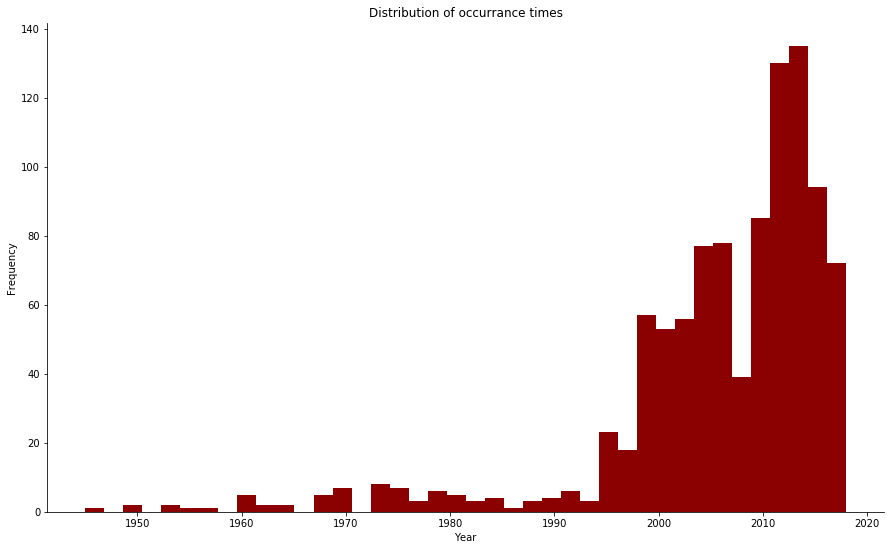

In [14]:
distribution_histogram(converted, 'year')

<font color='#660066'>
    
### Location

<font color='#660066'>

As most of the reportings are from the US, we are showing the distribution of reports from the different states. <br />
The data is not normalized at the moment.

In [ ]:
df_every_thing = replace_empty_with_nan(df_every_thing, 'Location')

In [ ]:
sightings_per_state_unnormalized(df_ufo_reports)

<font color='#660066'>

### Shape

<font color='#660066'>

The shapes feature consist of 31 different shapes, with the most populated being a 'light source'.

In [ ]:
df_every_thing = replace_empty_with_nan(df_every_thing, 'Shape')

<font color='#660066'>
    
### Duration

<font color='#660066'>

The duration is a user created data format, with lots of different formats, thus the cleaning and parsing of this data will take a large effort.

In [ ]:
df_every_thing = replace_empty_with_nan(df_every_thing, 'Duration')

<font color='#660066'>

### Summary

<font color='#660066'>

User made input as the summary about the witnessed UFO sighting of varying length. 

In [ ]:
df_every_thing = replace_empty_with_nan(df_every_thing, 'Shape')

<font color='#660066'>
   

## Milestone 3

- Analyze words, keywords. 
- Read into sentiment analysis, to see if we can apply it to our case.
- Clean duration column
- Analyze if the people were at the time of the sighting
- Split NUFORC nodes
- Check for NUFORC generated HOAX messages
- Check out dem videos
- Keywords for sleep, dropping the reports which might have been dreams/sleep paralysis induced visions.
- Time of occurance/duration correlation
- Weather data (historic weather data, cloudy, sunny, storm, etc), general trends in US states (months with higher percipitation), sort the data by month and see which months have a higher rate of sightings (look in the years where there are the most sightings)
- Filter out MADAR data, see how much our dataset changes
- Analyze what shapes are associated with what feelings? 
- Analyze what shapes are consistently reported at same locations?

- Sentiment Analysis for summary text
    - start with vizualization of text
    ([inspiration](https://www.jasondavies.com/wordtree/?source=obama.inauguration.2013.txt&prefix=we%20must%20act))
- Correlation of weather and reports
- Analyze madar sensor data (also in correlation with weather)
- Create report results plots (webpage)


<font color='#660066'>

## NUFORC Note Analyse

Distribution of NUFORC notes

In [15]:
dist = get_noforc_note_count_distribution(df_ufo_reports)
dist

0    78790
1    36101
2     2348
3       69
4        2
Name: nuforc_note, dtype: int64

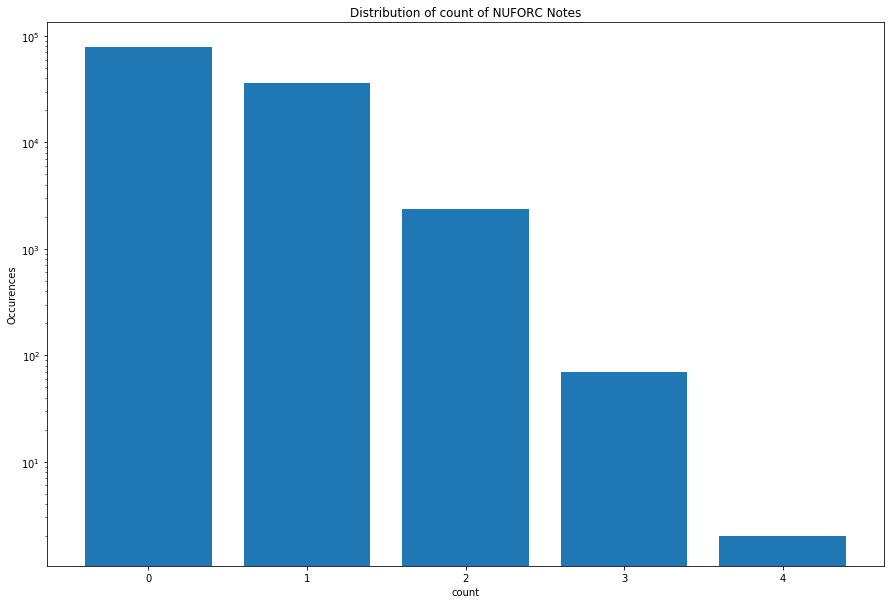

In [16]:
plot_distribution_of_notes(df_ufo_reports)


<font color='#660066'>

Filter all reports having n NUFORC Notes

In [ ]:
get_reports_having_n_notes(df_ufo_reports, 3).head()

In [41]:
df_reports.head()

,Duration,Location,State,Occurred,Posted,Reported,Shape,Summary,url,nuforc_note,link
0,10 minutes,Lutz,FL,10/30/2018 23:30,11/9/2018,10/30/2018 8:54:06 PM 20:54,,['Blinking white light that moved every few se...,http://www.nuforc.org/webreports/143/S143627.html,[((NUFORC Note: We have attempted to contact ...,[]
4,4-5 minutes,Bridgewater,NJ,11/23/2011 00:45 (Entered as : 11/23/11 00:45),6/5/2012,6/5/2012 12:37:48 PM 12:37,,['EXPLAINED: Bright lights in Somerset county ...,http://www.nuforc.org/webreports/089/S89377.html,[((NUFORC Note: Witness elects to remain tota...,[http://www.nj.com/news/index.ssf/2011/11/brig...
5,2 min,South Fork,CO,10/4/2001 14:00 (Entered as : 10/04/01 14:00),3/21/2003,10/15/2001 1:27:41 PM 13:27,Cigar,"['Shinny Cigar shape in sky on clear day.', 'D...",http://www.nuforc.org/webreports/019/S19862.html,[],[]
6,10 minutes,Hattiesburg,MS,12/17/2014 20:00 (Entered as : 12/17/14 20:00),8/13/2015,8/9/2015 9:11:19 PM 21:11,Triangle,['I saw a triangular UFO with red and white li...,http://www.nuforc.org/webreports/121/S121007.html,[],[]
7,5-10 seconds,LaBelle,FL,12/17/2014 17:19 (Entered as : 12/17/2014 17...,12/18/2014,12/17/2014 6:21:13 PM 18:21,Triangle,"['White Triangle in South Florida', 'My co-wor...",http://www.nuforc.org/webreports/116/S116071.html,[],[]


In [4]:
dummy_time = df_reports['Duration'].copy()

In [5]:
dummy_time = dummy_time.to_frame()
dummy_time.head()

,Duration
0,10 minutes
1,NaN
2,NaN
3,NaN
4,4-5 minutes


## Things we drop
We are dropping all of the durations where the length of duration is more than a day. After manual inspection of random samples from the durations which are longer than a day, I noticed that practically all of them were describing events that occured over the time period and not for the duration, thus we decided to drop them manually.
Also, as we are working only with the locations in the US, we drop all of the inputs which are not from the states.

In [496]:
df_reports

,Unnamed: 0,Duration,Location,Occurred,Posted,Reported,Shape,Summary,url
0,0,10 minutes,"Lutz, FL",10/30/2018 23:30,11/9/2018,10/30/2018 8:54:06 PM 20:54,,['Blinking white light that moved every few se...,http://www.nuforc.org/webreports/143/S143627.html
1,1,NaN,"Morrow, IN",10/28/2018 22:27 (Entered as : 10/28/18 22:27),11/9/2018,10/31/2018 6:12:49 AM 06:12,,['MADAR Node 127'],http://www.nuforc.org/webreports/143/S143631.html
2,10,NaN,"New London, IA",10/19/2018 09:13 (Entered as : 10/19/18 09:13),10/25/2018,10/24/2018 7:40:17 AM 07:40,,['MADAR Node 99 test facility'],http://www.nuforc.org/webreports/143/S143567.html
3,100,NaN,"Norwalk, CT",7/9/2018 20:41 (Entered as : 07/09/18 20:41),7/19/2018,7/16/2018 7:57:32 AM 07:57,,['MADAR Node 103'],http://www.nuforc.org/webreports/142/S142262.html
4,1000,4-5 minutes,"Bridgewater, NJ",11/23/2011 00:45 (Entered as : 11/23/11 00:45),6/5/2012,6/5/2012 12:37:48 PM 12:37,,['EXPLAINED: Bright lights in Somerset county ...,http://www.nuforc.org/webreports/089/S89377.html
5,10000,2 min,"South Fork, CO",10/4/2001 14:00 (Entered as : 10/04/01 14:00),3/21/2003,10/15/2001 1:27:41 PM 13:27,Cigar,"['Shinny Cigar shape in sky on clear day.', 'D...",http://www.nuforc.org/webreports/019/S19862.html
6,100000,10 minutes,"Hattiesburg, MS",12/17/2014 20:00 (Entered as : 12/17/14 20:00),8/13/2015,8/9/2015 9:11:19 PM 21:11,Triangle,['I saw a triangular UFO with red and white li...,http://www.nuforc.org/webreports/121/S121007.html
7,100001,5-10 seconds,"LaBelle, FL",12/17/2014 17:19 (Entered as : 12/17/2014 17...,12/18/2014,12/17/2014 6:21:13 PM 18:21,Triangle,"['White Triangle in South Florida', 'My co-wor...",http://www.nuforc.org/webreports/116/S116071.html
8,100002,30 seconds,"Maryland Heights, MO",12/16/2014 17:15 (Entered as : 12/16/2014 17...,12/18/2014,12/16/2014 9:33:20 PM 21:33,Triangle,['I was driving on my motorcycle on hwy 141 at...,http://www.nuforc.org/webreports/116/S116064.html
9,100003,:60,"Fort Mill, SC",12/16/2014 17:00 (Entered as : 12/16/14 17:00),12/18/2014,12/16/2014 7:01:22 PM 19:01,Triangle,['Triangular craft with lights are corners wit...,http://www.nuforc.org/webreports/116/S116060.html


In [773]:
def clean_duration_get_min(df):
    """
    Cleans the duration section by dropping all values, which are more than a week
    Cleans the time formats and converts all of the to 'min'
    By cleaning the data we are left with 86% of the intial data,
    Which is reasonable for us, as initially there were about 10000 different
    Time formats
    Returns:
        --cleaned series with updated durations in min
    """
    df_dummy = df.Duration.copy()
    df_dummy = df_dummy.to_frame()
    df_dummy.Duration = df_dummy.Duration.str.lower()
    df_dummy = df_dummy.dropna()
    df_dummy['time_format'] = df_dummy.Duration
    hr_time = df_dummy.copy()
    hr_time.Duration = hr_time.Duration[hr_time.Duration.str.contains('1 hr')]
    hr_time = hr_time.dropna()
    hr_time.Duration = 60
    hr_time.time_format = 'min'
    hrs_time = dummy_time.copy()
    hrs_time.Duration = hrs_time.Duration[hrs_time.Duration.str.contains('hrs')]
    hrs_time = hrs_time.dropna()
    hrs_time.Duration = hrs_time.Duration.str.replace('[:-]', '.')
    hrs_time.Duration = hrs_time.Duration.str.replace(' 1/2', '.5')
    hrs_time.Duration = hrs_time.Duration.str.replace('/', '.')
    repl = lambda m: m.group('one')
    hrs_time.Duration = hrs_time.Duration.str.replace(r"(?P<one>.*)hrs.*", repl, regex=True)
    hrs_time.Duration = hrs_time.Duration.str.replace(r"[^0-9]*(?P<one>[0-9][0-9 \.]*)[\w\. ]*", repl, regex=True)
    hrs_time.Duration = hrs_time.Duration.str.replace('[+a-z ]', '')
    hrs_time.time_format = 'hour'
    manual_drop_hrs = [111938, 97125, 92361, 87440, 110228, 45333, 80653, 58194, 55810, 
                       54939, 110807, 54694, 30841, 57254]
    hrs_time = hrs_time.drop(manual_drop_hrs)
    hrs_time.Duration = hrs_time.Duration[~(hrs_time.Duration == '')]
    hrs_time = hrs_time.dropna()
    hrs_time.Duration = hrs_time.Duration.astype(float)
    hrs_time.Duration = hrs_time.Duration*60
    hrs_time.time_format = 'min'
    hour_time = dummy_time.copy()
    hour_time.Duration = hour_time.Duration[hour_time.Duration.str.contains('hour')]
    hour_time = hour_time.dropna()
    hour_time.Duration = hour_time.Duration.str.replace('[:-]', '.')
    hour_time.Duration = hour_time.Duration.str.replace(' 1/2', '.5')
    hour_time.Duration = hour_time.Duration.str.replace('/', '.')
    hour_time.Duration = hour_time.Duration.str.replace(r"(?P<one>.*)hour.*", repl, regex=True)
    hour_time.Duration = hour_time.Duration.str.replace(r"[^0-9]*(?P<one>[0-9][0-9 \.]*)[\w\. ]*", repl, regex=True)
    hour_time.Duration = hour_time.Duration.str.replace('[+a-z ?\(\)&"`,!>;]', '')
    hour_time.Duration = hour_time.Duration.str.replace('([.]{2,})', '')
    manual_drop_hours = [109182, 102324, 96844, 93487, 93353, 80915, 88291, 78633,
                         63452, 66319, 67243, 44816, 22126, 30095, 68130, 91121, 
                        80095, 71731, 61714, 38278, 24674, 107114, 111918]
    hour_time = hour_time.drop(manual_drop_hours)
    hour_time.Duration = hour_time.Duration.str.replace('\.$', '')
    hour_time.time_format = 'hour'
    hour_time.Duration = hour_time.Duration[~(hour_time.Duration == '')]
    hour_time = hour_time.dropna()
    hour_time.Duration = hour_time.Duration.astype(float)
    hour_time.Duration = hour_time.Duration*60
    hour_time.time_format = 'min'
    minutes_time = dummy_time.copy()
    minutes_time.Duration = minutes_time.Duration.dropna()[minutes_time.Duration.dropna().str.contains('min')]
    minutes_time.time_format = 'min'
    minutes_time = minutes_time.dropna()
    minutes_time.Duration = minutes_time.Duration.str.replace(' 1/2', '.5')
    minutes_time.Duration = minutes_time.Duration.str.replace('to', '-')
    minutes_time.Duration = minutes_time.Duration.str.replace('or', '-')
    minutes_time.Duration = minutes_time.Duration.str.replace('[/:]', '.')
    minutes_time['Duration'] = minutes_time.Duration.str.replace(r"(?P<one>.*)hour.*", repl, regex=True)
    minutes_time['Duration'] = minutes_time.Duration.str.replace(r"[^0-9]*(?P<one>[0-9][0-9 -\.]*)[\w\. ]*", repl, regex=True)
    minutes_time['Duration'] = minutes_time.Duration.str.replace('[+a-z ?±*\(\)½!<>\\\\=~&"á`,\'!>;\[\]@]', '')
    minutes_time['Duration'] = minutes_time.Duration.str.replace('([.]{2,})', '')
    minutes_time['Duration'] = minutes_time.Duration.str.replace('([-]{2,})', '')
    minutes_manual_drop = [2708, 7632, 17491, 26323, 17743, 19051, 21642, 25011,
                           27849, 28293, 35538, 39992, 75636, 78172, 82754, 93849,
                           95787, 4126, 24350, 95915, 102106, 4627, 85033, 85683, 
                           14141, 16443, 69234, 77029, 101165, 42895, 19145, 56129, 
                          75795, 115300, 113583, 112874, 105620, 88135, 87478, 75795, 
                          60077, 55454, 78279, 113942, 43457, 4597, 6962, 9217, 19169, 
                           32546, 41128, 61391, 63575, 82235, 101547, 32357, 89937]
    minutes_time = minutes_time.drop(minutes_manual_drop)
    minutes_time['Duration'] = minutes_time.Duration.str.replace('\-$', '')
    minutes_time.Duration = minutes_time.Duration.str.replace('\.$', '')
    minutes_time.Duration = minutes_time.Duration.str.replace('\.-$', '')
    minutes_time.Duration = minutes_time.Duration[~(minutes_time.Duration == '')]
    minutes_time = minutes_time.dropna()
    extended_duration = minutes_time[minutes_time.Duration.str.contains('-')]
    seperated_duration = extended_duration.Duration.str.split('-')
    seperated_duration = seperated_duration[~(seperated_duration.str[0] == '')]
    seperated_duration = seperated_duration[~(seperated_duration.str[1] == '')]
    calculated_averages_of_durations = (seperated_duration.str[0].astype(float)+seperated_duration.str[1].astype(float))/2
    minutes_time.update(calculated_averages_of_durations)
    minutes_time.Duration = minutes_time.Duration.astype(str).str.replace('[-]', '')
    minutes_time.Duration = minutes_time.Duration[~(minutes_time.Duration == '')]
    minutes_time = minutes_time.dropna()
    minutes_time.Duration = minutes_time.Duration.astype(float)

    sec_time = dummy_time.copy()
    sec_time.Duration = sec_time.Duration.dropna()[sec_time.Duration.dropna().str.contains('sec')]
    sec_time.time_format = 'sec'
    sec_time = sec_time.dropna()
    sec_time.Duration = sec_time.Duration.str.replace(' 1/2', '.5')
    sec_time.Duration = sec_time.Duration.str.replace('to', '-')
    sec_time.Duration = sec_time.Duration.str.replace('or', '-')
    sec_time.Duration = sec_time.Duration.str.replace('[/:]', '.')
    repl = lambda m: m.group('one')
    sec_time['Duration'] = sec_time.Duration.str.replace(r"(?P<one>.*)sec.*", repl, regex=True)
    sec_time['Duration'] = sec_time.Duration.str.replace(r"[^0-9]*(?P<one>[0-9][0-9 -\.]*)[\w\. ]*", repl, regex=True)
    sec_time['Duration'] = sec_time.Duration.str.replace('[+a-z ?±*\(\)½!<>\\\\=~&"á`,\'!>;\[\]@]', '')
    sec_time['Duration'] = sec_time.Duration.str.replace('([.]{2,})', '')
    sec_time['Duration'] = sec_time.Duration.str.replace('([-]{2,})', '')
    sec_time['Duration'] = sec_time.Duration.str.replace('\-$', '')
    sec_manual_drop = [17067, 42074, 21247]
    sec_time = sec_time.drop(sec_manual_drop)
    sec_time.Duration = sec_time.Duration.str.replace('\.$', '')
    sec_time.Duration = sec_time.Duration.str.replace('\.-$', '')
    sec_time.Duration = sec_time.Duration[~(sec_time.Duration == '')]
    sec_time = sec_time.dropna()

    sec_extended_duration = sec_time[sec_time.Duration.str.contains('-')]
    sec_seperated_duration = sec_extended_duration.Duration.str.split('-')
    sec_seperated_duration = sec_seperated_duration[~(sec_seperated_duration.str[0] == '')]
    sec_seperated_duration = sec_seperated_duration[~(sec_seperated_duration.str[1] == '')]
    sec_calculated_averages_of_durations = (sec_seperated_duration.str[0].astype(float) + 
                                        sec_seperated_duration.str[1].astype(float))/2

    sec_time.update(sec_calculated_averages_of_durations)
    sec_time.Duration = sec_time.Duration.astype(str).str.replace('[-]', '')
    sec_time.Duration = sec_time.Duration[~(sec_time.Duration == '')]
    sec_time = sec_time.dropna()
    sec_time.Duration = sec_time.Duration.astype(float)
    sec_time.Duration = sec_time.Duration/60
    sec_time.time_format = 'min'

    duration_list = [sec_time, minutes_time, hr_time, hrs_time, hour_time]
    duration = pd.concat(duration_list).sort_index()
    duration = duration.Duration
    
    return duration

In [45]:
def get_time_of_occurrence(data):
    """
    Takes the input of the whole dataframe
    Return:
       - Time and date of occurrance and report
       - Year of occurrance
    """
    occur_report = data[['Occurred', 'Reported']].copy()
    df_time_occur_report = occur_report.assign(Occurred=occur_report.Occurred.str.split('(',n=1).str[0])
    df_time_occur_report.Reported = pd.DataFrame(pd.to_datetime(occur_report.Reported))
    #Create new column for years
    #df_time_occur_report['year'] = np.nan
    df_time_occur_report.Occurred = df_time_occur_report.Occurred.str.strip()
    converted_time = to_datetime_add_year(df_time_occur_report.Occurred)
    df_time_occur_report.Occurred = converted_time
    #Assigns years of occurance to the column
    #for i in range(len(df_time_occur_report.Occurred)):
     #   df_time_occur_report.year[i] = df_time_occur_report.Occurred[i].year
    data.Occurred = df_time_occur_report.Occurred
    data.Reported = df_time_occur_report.Reported
    return data

def to_datetime_add_year(date):
    """
    Changes the date format of the dataframe
    Returns:
       - Updated time formats
    """
    converted = pd.DataFrame(pd.to_datetime(date,format='%m/%d/%Y %H:%M',
                   errors = 'coerce', exact=True))
    converted_2 = pd.DataFrame(pd.to_datetime(date,format='%m/%d/%Y',
                   errors = 'coerce', exact=True))
    values = converted_2[~converted_2.Occurred.isnull()]
    converted.update(values)

    return converted

def replace_empty_with_nan(data, feature):
    """
    Checks for the missing values in our dataset
    And transforms the missing values into NaNs
    """
    feature_names = list(data)
    data[feature] = data[feature].str.strip()
    data[feature] = np.where(data[feature] != '', data[feature], np.NaN)
    nan_count = data[feature].isna().sum()
    
    print('{} feature has {} missing values'.format(feature, nan_count))
    return data


def distribution_histogram(data, feature):
    plotting_data = data[feature].dropna()
    plt.figure(figsize=(15,9))
    plot = plt.hist(plotting_data, bins = 40, color = '#8B0000')
    # Tweak the visual presentation
    #plt.xaxis.grid(True)
    plt.title('Distribution of occurrance times')
    plt.xlabel('Year')
    plt.ylabel('Frequency')
    sns.despine(trim=False, left=False)


In [46]:
df_occurance = get_time_of_occurrence(df_reports)

In [47]:
df_occurance.head()

,Duration,Location,State,Occurred,Posted,Reported,Shape,Summary,url,nuforc_note,link
0,10 minutes,Lutz,FL,2018-10-30 23:30:00,11/9/2018,2018-10-30 20:54:00,,['Blinking white light that moved every few se...,http://www.nuforc.org/webreports/143/S143627.html,[((NUFORC Note: We have attempted to contact ...,[]
4,4-5 minutes,Bridgewater,NJ,2011-11-23 00:45:00,6/5/2012,2012-06-05 12:37:00,,['EXPLAINED: Bright lights in Somerset county ...,http://www.nuforc.org/webreports/089/S89377.html,[((NUFORC Note: Witness elects to remain tota...,[http://www.nj.com/news/index.ssf/2011/11/brig...
5,2 min,South Fork,CO,2001-10-04 14:00:00,3/21/2003,2001-10-15 13:27:00,Cigar,"['Shinny Cigar shape in sky on clear day.', 'D...",http://www.nuforc.org/webreports/019/S19862.html,[],[]
6,10 minutes,Hattiesburg,MS,2014-12-17 20:00:00,8/13/2015,2015-08-09 21:11:00,Triangle,['I saw a triangular UFO with red and white li...,http://www.nuforc.org/webreports/121/S121007.html,[],[]
7,5-10 seconds,LaBelle,FL,2014-12-17 17:19:00,12/18/2014,2014-12-17 18:21:00,Triangle,"['White Triangle in South Florida', 'My co-wor...",http://www.nuforc.org/webreports/116/S116071.html,[],[]


In [30]:
kautkas = pd.DataFrame(pd.to_datetime(reported))#,format='%m/%d/%Y %H:%M',
                  # errors = 'coerce', exact=True))

In [33]:
kautkas.Reported.dtype

dtype('<M8[ns]')